# <span style='color:SteelBlue'>P6 - Segmentez des clients d'un site e-commerce</span>

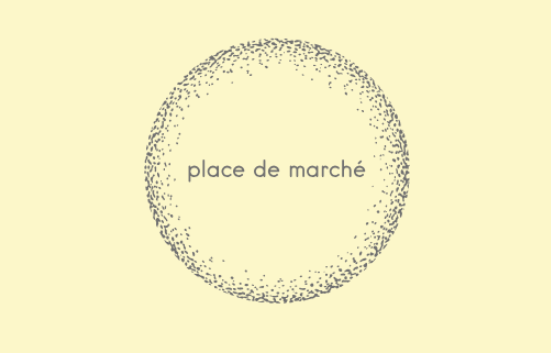

# <span class='bg-primary'>P6_02 - IMAGES - Données Images</span>

# <span class='bg-primary'>P6_02_02 - CNN - COMBINAISON TEXTES + IMAGES - CLASSIFICATION SUPERVISÉE</span>

## <span style='background:Thistle'>Sommaire du notebook</span> 

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

Ce Notebook traite les images avec les applications Keras CNN Transfert learning avec classification supervisée.

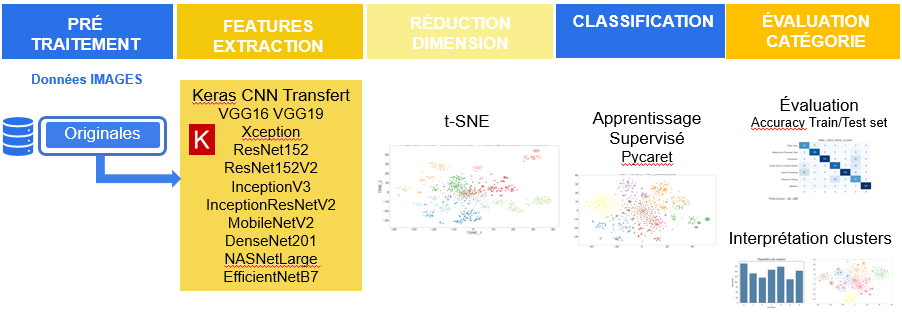

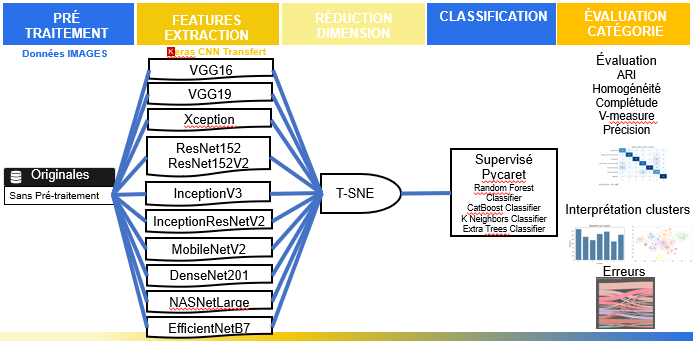

## <span style='background:Thistle'>1. Introduction</span>

**Mission**
*****
Réaliser une première **étude de faisabilité** d'un moteur de **classification d'articles** basé sur une **image et une description** pour l'**automatisation** de l'attribution de la **catégorie de l'article**.

**Objectifs**
*****
- analyser le jeu de données,
- réaliser :
    - un prétraitement des images,
    - un prétraitement des descriptions des produits
    - une réduction de dimension, 
    - puis un clustering. 

La représentation graphique aidera à convaincre que cette approche de modélisation permettra bien de regrouper des produits de même catégorie.

**Contraintes**
***
Afin d’extraire les features, mettre en œuvre a minima un algorithme de type SIFT / ORB / SURF (un algorithme de type CNN Transfer Learning peut éventuellement être utilisé en complément, s’il peut apporter un éclairage supplémentaire à la démonstration).

**Sources**
*****
- [Jeu de données](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip)

In [3]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import jyquickhelper
import numpy as np
import pandas as pd
import os
import pickle
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import outils_data
import outils_images
import outils_segmentation
import outils_nlp
# Réduction dimension
from sklearn.manifold import TSNE
# Clustering
from sklearn.cluster import KMeans
# CNN Applications Keras
import keras
from keras.preprocessing import image
import tensorflow as tf

# Warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep8
%load_ext pycodestyle_magic
%pycodestyle_on
# %pycodestyle_off

# Versions
print('Version des librairies utilisées :')
print('jyquickhelper         : ' + jyquickhelper.__version__)
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Keras                 : ' + keras.__version__)
print('Outils dataframe      : ' + outils_data.__version__)
print('Outils images         : ' + outils_images.__version__)
print('Outils segmentation   : ' + outils_segmentation.__version__)
print('Outils NLP            : ' + outils_nlp.__version__)
now = datetime.now().isoformat()
print('Lancé le           : ' + now)

Version des librairies utilisées :
jyquickhelper         : 0.4.220
Python                : 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
NumPy                 : 1.19.5
Pandas                : 1.2.4
Keras                 : 2.4.3
Outils dataframe      : 0.0.2
Outils images         : 0.0.0
Outils segmentation   : 0.0.0
Outils NLP            : 0.0.0
Lancé le           : 2021-07-02T11:41:36.246783


In [4]:
dico_pd_option = {
    'display.max_rows': 400,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 5,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

## <span style='background:Thistle'>2. Jeu de données</span>

### <span style='background:PowderBlue'>2.1. Chargement du jeu de données</span>

In [5]:
# Nombre aléatoire pour la reproductibilité des résultats
seed = 21

In [6]:
# Chargement du jeu de données
data_all = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')

In [6]:
# Taille : nombre de lignes/colonnes
nRow, nVar = data_all.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 1050 lignes et 15 variables.


In [7]:
data_all.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that ...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""key""=>""Model Name"", ""value""=>""Abstract Polyester Door Curtain Set Of 2""}, {""key""=>""Model ID"", ""value""=>""Duster25""}, {""key""=>""Color"", ""value""=>""Multicolor""}, {""key""=>""Length"", ""value""=>""213 cm""}, {""key""=>""Number of Contents in Sales Package"", ""value""=>""Pack of 2""}, {""key""=>""Sales Package"", ""value""=>""2 Curtains""}, {""key""=>""Material"", ""value""=>""Polyester""}]}"
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...""]",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""value""=>""Cotton""}, {""key""=>""Design"", ""value""=>""Self Design""}, {""key""=>""Brand"", ""value""=>""Sathiyas""}, {""key""=>""Type"", ""value""=>""Bath Towel""}, {""key""=>""GSM"", ""value""=>""500""}, {""key""=>""Model Name"", ""value""=>""Sathiyas cotton bath towel""}, {""key""=>""Ideal For"", ""value""=>""Men, Women, Boys, Girls""}, {""key""=>""Model ID"", ""value""=>""asvtwl322""}, {""key""=>""Color"", ""value""=>""Red, Yellow, Blue""}, {""key""=>""Size"", ""value""=>""Mediam""}, {""key""=>""Length"", ""value""=>""30 inch""}, {""key""=>""Width"", ""value""=>""60 inch""}, {""key""=>""Number of Contents in Sales Package"", ""value""=>""3""}, {""key""=>""Sales Package"", ""value""=>""3 Bath Towel""}]}"


### <span style='background:PowderBlue'>2.2. Préparation du dataframe de travail pour le traitement des images</span>

**image_loc**

- La variable '**image**' est constituée de la concaténation du e l'identifiant unique (ex : 02127f52e96fb72c66bf081d25104ef8) suivi de '.jpg' : **02127f52e96fb72c66bf081d25104ef8.jpg**.
- Ajout d'une nouvelle variable **image_loc** contenant le chemin du répertoire de stockage des images ainsi que du nom du fichier image pour des appels moins verbeux dans le code.

In [7]:
# Ajout variable image_loc
# ex : data/Images/02127f52e96fb72c66bf081d25104ef8.jpg
path = 'data/Images/'
data_all['image_loc'] = [path + row for row in data_all['image']]

**Récupération de la première sous-catégorie**

In [8]:
# Découpe les sous-catégories dans des nouvelles variables du dataframe
work = data_all['product_category_tree'].str.split(' >> ', expand=True)
data_all['Categorie_1'] = work[0]
# Nettoye les [" et "]
data_all.replace('\\["', '', regex=True, inplace=True)
data_all.replace('"\\]', '', regex=True, inplace=True)

In [9]:
data = data_all.copy()
data = data[['image', 'image_loc', 'Categorie_1', ]]
data.head(3)

,image,image_loc,Categorie_1
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,data/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,data/Images/7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,data/Images/64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care


In [10]:
# TARGET = premier niveau de catégorie
data_cat = data['Categorie_1']

In [11]:
# Dataframe de sauvegarde des résultats des scores
# df_accuracy_class = pd.DataFrame()
# Chargement des données de sauvegarde des résultats class. supervisée
df_accuracy_class = pd.read_csv('data_accuracy_classification_images.csv')

## <span style='background:Thistle'>3. CNN - Convolution Neural Network</span>

### <span style='background:PowderBlue'>3.1. VGG16</span>

**ÉTAPE 1 - Import de la matrice dense sauvegardée**

In [24]:
with open('sauvegarde/df_vgg16_vectors.pickle', 'rb') as vectors:
    df_vgg16_vectors = pickle.load(vectors)

**ÉTAPE 2 - Classification supervisée Pycaret**

In [25]:
titre = 'TSNE_VGG16'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7249,0.9211,0.7210,0.7372,0.7237,0.6785,0.6808,0.0370
et,Extra Trees Classifier,0.7221,0.9271,0.7180,0.7332,0.7205,0.6751,0.6773,0.0350
catboost,CatBoost Classifier,0.7221,0.9350,0.7208,0.7374,0.7207,0.6753,0.6783,1.7570
xgboost,Extreme Gradient Boosting,0.7085,0.9249,0.7053,0.7221,0.7073,0.6593,0.6618,0.4310
knn,K Neighbors Classifier,0.7057,0.9051,0.6981,0.7250,0.7040,0.6556,0.6592,0.1910
gbc,Gradient Boosting Classifier,0.7002,0.9191,0.6960,0.7067,0.6959,0.6496,0.6522,0.0980
lightgbm,Light Gradient Boosting Machine,0.6826,0.9211,0.6796,0.6930,0.6796,0.6290,0.6318,0.2150
dt,Decision Tree Classifier,0.6704,0.8076,0.6670,0.6825,0.6680,0.6148,0.6176,0.0050
qda,Quadratic Discriminant Analysis,0.6417,0.8728,0.6280,0.6588,0.6261,0.5798,0.5878,0.0070
nb,Naive Bayes,0.6375,0.8569,0.6256,0.6533,0.6239,0.5750,0.5823,0.0060


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7310,0.9347,0.7335,0.7528,0.7369,0.6857,0.6875


Clusters,Nombre,%
Baby Care,49,15.51000
Beauty and Personal Care,34,10.76000
Computers,48,15.19000
Home Decor & Festive Needs,43,13.61000
Home Furnishing,52,16.46000
Kitchen & Dining,48,15.19000
Watches,42,13.29000


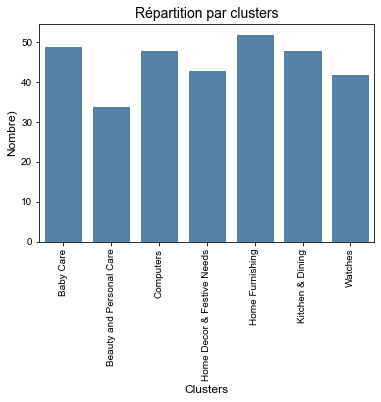

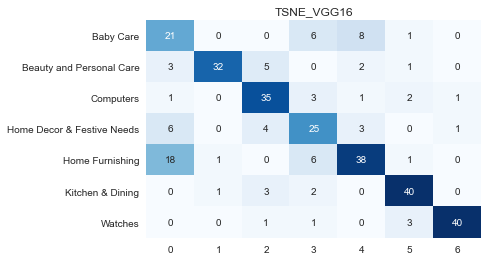

'Précision: 73.1%'

                            precision    recall  f1-score   support

                 Baby Care       0.43      0.58      0.49        36
  Beauty and Personal Care       0.94      0.74      0.83        43
                 Computers       0.73      0.81      0.77        43
Home Decor & Festive Needs       0.58      0.64      0.61        39
           Home Furnishing       0.73      0.59      0.66        64
          Kitchen & Dining       0.83      0.87      0.85        46
                   Watches       0.95      0.89      0.92        45

                  accuracy                           0.73       316
                 macro avg       0.74      0.73      0.73       316
              weighted avg       0.75      0.73      0.74       316


In [26]:
outils_nlp.classifier_pycaret(data_cat, df_vgg16_vectors, titre)

In [29]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_images.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                               '0.7249', '0.7310', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
0,TSNE_VGG16,0.7249,0.7310


### <span style='background:PowderBlue'>3.2. VGG19</span>

**ÉTAPE 1 - Import de la matrice dense sauvegardée**

In [30]:
with open('sauvegarde/df_vgg19_vectors.pickle', 'rb') as vectors:
    df_vgg19_vectors = pickle.load(vectors)

**ÉTAPE 2 - Classification supervisée Pycaret**

In [31]:
titre = 'TSNE_VGG19'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7192,0.9368,0.7163,0.7401,0.7225,0.6719,0.6743,1.6890
rf,Random Forest Classifier,0.7178,0.9332,0.7143,0.7387,0.7201,0.6701,0.6728,0.0360
et,Extra Trees Classifier,0.7123,0.9324,0.7078,0.7319,0.7128,0.6635,0.6667,0.0330
xgboost,Extreme Gradient Boosting,0.7013,0.9254,0.6986,0.7205,0.7035,0.6510,0.6536,0.4660
gbc,Gradient Boosting Classifier,0.6987,0.9232,0.6966,0.7231,0.7030,0.6479,0.6505,0.0890
lightgbm,Light Gradient Boosting Machine,0.6918,0.9282,0.6879,0.7135,0.6937,0.6397,0.6432,0.2350
dt,Decision Tree Classifier,0.6878,0.8179,0.6849,0.6979,0.6876,0.6353,0.6369,0.0050
knn,K Neighbors Classifier,0.6851,0.9036,0.6814,0.7045,0.6861,0.6318,0.6348,0.0070
lda,Linear Discriminant Analysis,0.6511,0.8879,0.6395,0.6543,0.6356,0.5913,0.5972,0.0050
qda,Quadratic Discriminant Analysis,0.6483,0.8989,0.6396,0.6773,0.6424,0.5882,0.5938,0.0050


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7500,0.9409,0.7520,0.7678,0.7547,0.7079,0.7095


Clusters,Nombre,%
Baby Care,49,15.51000
Beauty and Personal Care,37,11.71000
Computers,49,15.51000
Home Decor & Festive Needs,40,12.66000
Home Furnishing,52,16.46000
Kitchen & Dining,43,13.61000
Watches,46,14.56000


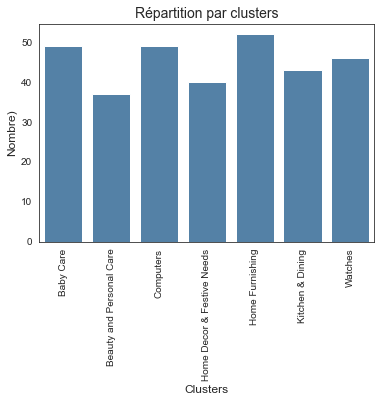

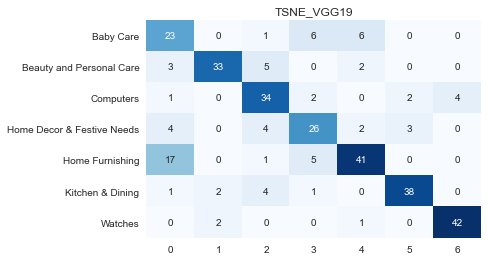

'Précision: 75.0%'

                            precision    recall  f1-score   support

                 Baby Care       0.47      0.64      0.54        36
  Beauty and Personal Care       0.89      0.77      0.82        43
                 Computers       0.69      0.79      0.74        43
Home Decor & Festive Needs       0.65      0.67      0.66        39
           Home Furnishing       0.79      0.64      0.71        64
          Kitchen & Dining       0.88      0.83      0.85        46
                   Watches       0.91      0.93      0.92        45

                  accuracy                           0.75       316
                 macro avg       0.76      0.75      0.75       316
              weighted avg       0.77      0.75      0.75       316


In [32]:
outils_nlp.classifier_pycaret(data_cat, df_vgg19_vectors, titre)

In [33]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_images.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                               '0.7192', '0.7500', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
1,TSNE_VGG19,0.7192,0.7500


### <span style='background:PowderBlue'>3.3. Xception</span>

**ÉTAPE 1 - Import de la matrice dense sauvegardée**

In [34]:
with open('sauvegarde/df_xcept_vectors.pickle', 'rb') as vectors:
    df_xcept_vectors = pickle.load(vectors)

**ÉTAPE 2 - Classification supervisée Pycaret**

In [35]:
titre = 'TSNE_XCEPTION'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8296,0.9344,0.8322,0.8402,0.8274,0.8011,0.8036,0.1880
catboost,CatBoost Classifier,0.8295,0.9559,0.8307,0.8399,0.8284,0.8010,0.8032,1.7520
et,Extra Trees Classifier,0.8281,0.9479,0.8301,0.8420,0.8255,0.7994,0.8025,0.0350
rf,Random Forest Classifier,0.8268,0.9514,0.8286,0.8398,0.8259,0.7978,0.8004,0.0380
xgboost,Extreme Gradient Boosting,0.8173,0.9537,0.8185,0.8284,0.8157,0.7867,0.7891,0.3550
lightgbm,Light Gradient Boosting Machine,0.8131,0.9538,0.8133,0.8221,0.8118,0.7817,0.7837,0.2290
gbc,Gradient Boosting Classifier,0.8077,0.9497,0.8096,0.8182,0.8056,0.7754,0.7780,0.0950
dt,Decision Tree Classifier,0.7792,0.8713,0.7797,0.7907,0.7780,0.7423,0.7445,0.0060
qda,Quadratic Discriminant Analysis,0.7260,0.9301,0.7294,0.7301,0.7192,0.6802,0.6828,0.0060
lr,Logistic Regression,0.7233,0.9206,0.7213,0.7291,0.7187,0.6767,0.6789,0.4320


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.8228,0.9565,0.8156,0.8233,0.8229,0.7920,0.7921


Clusters,Nombre,%
Baby Care,37,11.71000
Beauty and Personal Care,40,12.66000
Computers,43,13.61000
Home Decor & Festive Needs,40,12.66000
Home Furnishing,65,20.57000
Kitchen & Dining,45,14.24000
Watches,46,14.56000


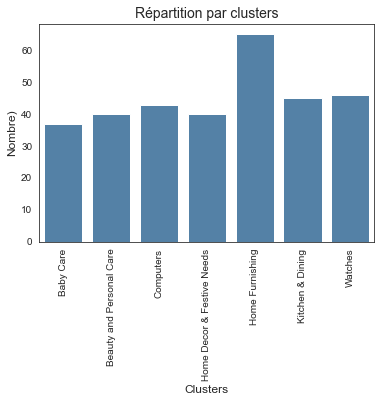

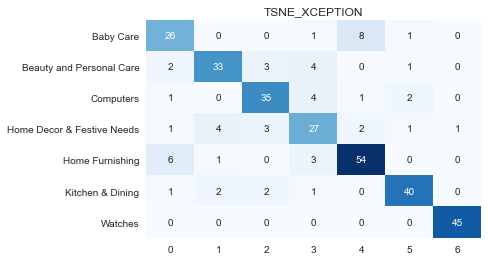

'Précision: 82.28%'

                            precision    recall  f1-score   support

                 Baby Care       0.70      0.72      0.71        36
  Beauty and Personal Care       0.82      0.77      0.80        43
                 Computers       0.81      0.81      0.81        43
Home Decor & Festive Needs       0.68      0.69      0.68        39
           Home Furnishing       0.83      0.84      0.84        64
          Kitchen & Dining       0.89      0.87      0.88        46
                   Watches       0.98      1.00      0.99        45

                  accuracy                           0.82       316
                 macro avg       0.82      0.82      0.82       316
              weighted avg       0.82      0.82      0.82       316


In [36]:
outils_nlp.classifier_pycaret(data_cat, df_xcept_vectors, titre)

In [37]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_images.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                               '0.8296', '0.8228', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
2,TSNE_XCEPTION,0.8296,0.8228


### <span style='background:PowderBlue'>3.4. ResNet152</span>

**ÉTAPE 1 - Import de la matrice dense sauvegardée**

In [38]:
with open('sauvegarde/df_rn152_vectors.pickle', 'rb') as vectors:
    df_rn152_vectors = pickle.load(vectors)

**ÉTAPE 2 - Classification supervisée Pycaret**

In [39]:
titre = 'TSNE_RESNET152'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7859,0.9473,0.7868,0.7984,0.7851,0.7501,0.7523,1.6920
knn,K Neighbors Classifier,0.7779,0.9333,0.7768,0.7919,0.7757,0.7406,0.7436,0.0070
rf,Random Forest Classifier,0.7779,0.9523,0.7795,0.7942,0.7763,0.7407,0.7435,0.0390
et,Extra Trees Classifier,0.7752,0.9524,0.7761,0.7914,0.7730,0.7374,0.7405,0.0350
xgboost,Extreme Gradient Boosting,0.7696,0.9421,0.7689,0.7904,0.7693,0.7308,0.7338,0.5080
lightgbm,Light Gradient Boosting Machine,0.7601,0.9431,0.7586,0.7778,0.7605,0.7198,0.7225,0.2440
gbc,Gradient Boosting Classifier,0.7492,0.9457,0.7484,0.7703,0.7496,0.7070,0.7102,0.0950
dt,Decision Tree Classifier,0.7466,0.8523,0.7473,0.7652,0.7435,0.7042,0.7082,0.0050
nb,Naive Bayes,0.7138,0.9231,0.7117,0.7377,0.7099,0.6652,0.6695,0.2330
qda,Quadratic Discriminant Analysis,0.7124,0.9252,0.7114,0.7367,0.7088,0.6637,0.6679,0.0060


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8259,0.9615,0.8130,0.8312,0.8264,0.7956,0.7963


Clusters,Nombre,%
Baby Care,34,10.76000
Beauty and Personal Care,35,11.08000
Computers,43,13.61000
Home Decor & Festive Needs,46,14.56000
Home Furnishing,69,21.84000
Kitchen & Dining,44,13.92000
Watches,45,14.24000


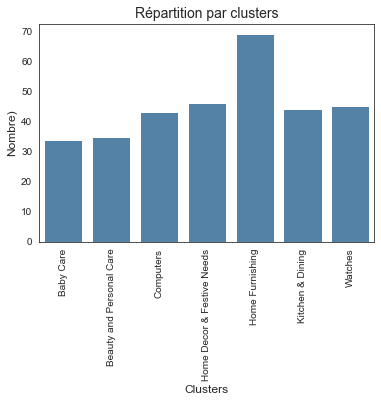

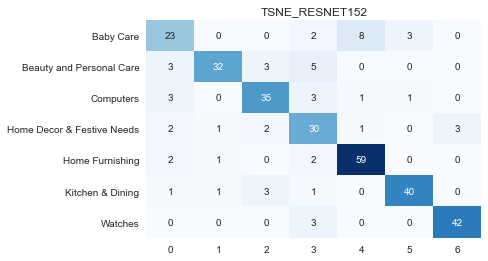

'Précision: 82.59%'

                            precision    recall  f1-score   support

                 Baby Care       0.68      0.64      0.66        36
  Beauty and Personal Care       0.91      0.74      0.82        43
                 Computers       0.81      0.81      0.81        43
Home Decor & Festive Needs       0.65      0.77      0.71        39
           Home Furnishing       0.86      0.92      0.89        64
          Kitchen & Dining       0.91      0.87      0.89        46
                   Watches       0.93      0.93      0.93        45

                  accuracy                           0.83       316
                 macro avg       0.82      0.81      0.82       316
              weighted avg       0.83      0.83      0.83       316


In [40]:
outils_nlp.classifier_pycaret(data_cat, df_rn152_vectors, titre)

In [41]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_images.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                               '0.7859', '0.8259', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
3,TSNE_RESNET152,0.7859,0.8259


### <span style='background:PowderBlue'>3.5. ResNet152V2</span>

**ÉTAPE 1 - Import de la matrice dense sauvegardée**

In [42]:
with open('sauvegarde/df_rn152v2_vectors.pickle', 'rb') as vectors:
    df_rn152v2_vectors = pickle.load(vectors)

**ÉTAPE 2 - Classification supervisée Pycaret**

In [43]:
titre = 'TSNE_RESNET152V2'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7875,0.9342,0.7885,0.8007,0.7877,0.7519,0.7539,0.0350
xgboost,Extreme Gradient Boosting,0.7847,0.9369,0.7843,0.7983,0.7833,0.7486,0.7512,0.5660
rf,Random Forest Classifier,0.7833,0.9404,0.7829,0.7963,0.7817,0.7470,0.7496,0.0380
catboost,CatBoost Classifier,0.7806,0.9456,0.7804,0.7945,0.7781,0.7438,0.7468,1.7430
lightgbm,Light Gradient Boosting Machine,0.7765,0.9420,0.7767,0.7892,0.7762,0.7390,0.7412,0.1920
gbc,Gradient Boosting Classifier,0.7697,0.9420,0.7678,0.7816,0.7688,0.7311,0.7333,0.0950
knn,K Neighbors Classifier,0.7684,0.9201,0.7669,0.7831,0.7686,0.7293,0.7316,0.1870
dt,Decision Tree Classifier,0.7479,0.8528,0.7443,0.7522,0.7451,0.7054,0.7070,0.0050
lr,Logistic Regression,0.6471,0.8901,0.6399,0.6614,0.6421,0.5871,0.5904,0.3520
qda,Quadratic Discriminant Analysis,0.6418,0.8947,0.6470,0.6577,0.6217,0.5826,0.5911,0.0060


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8259,0.9601,0.8233,0.8342,0.8273,0.7960,0.7968


Clusters,Nombre,%
Baby Care,41,12.97000
Beauty and Personal Care,37,11.71000
Computers,41,12.97000
Home Decor & Festive Needs,47,14.87000
Home Furnishing,64,20.25000
Kitchen & Dining,39,12.34000
Watches,47,14.87000


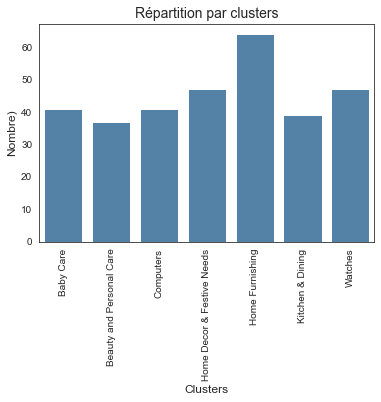

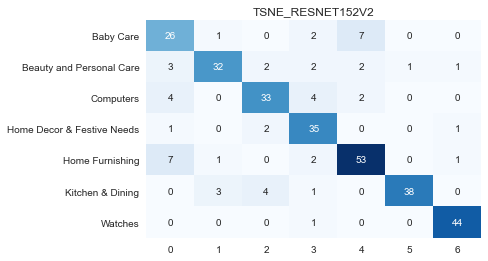

'Précision: 82.59%'

                            precision    recall  f1-score   support

                 Baby Care       0.63      0.72      0.68        36
  Beauty and Personal Care       0.86      0.74      0.80        43
                 Computers       0.80      0.77      0.79        43
Home Decor & Festive Needs       0.74      0.90      0.81        39
           Home Furnishing       0.83      0.83      0.83        64
          Kitchen & Dining       0.97      0.83      0.89        46
                   Watches       0.94      0.98      0.96        45

                  accuracy                           0.83       316
                 macro avg       0.83      0.82      0.82       316
              weighted avg       0.83      0.83      0.83       316


In [44]:
outils_nlp.classifier_pycaret(data_cat, df_rn152v2_vectors, titre)

In [45]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_images.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                               '0.7875', '0.8259', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
4,TSNE_RESNET152V2,0.7875,0.8259


### <span style='background:PowderBlue'>3.6. InceptionV3</span>

**ÉTAPE 1 - Import de la matrice dense sauvegardée**

In [46]:
with open('sauvegarde/df_incep_vectors.pickle', 'rb') as vectors:
    df_incep_vectors = pickle.load(vectors)

**ÉTAPE 2 - Classification supervisée Pycaret**

In [47]:
titre = 'TSNE_INCEPTIONV3'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7969,0.9492,0.7954,0.8066,0.7952,0.7627,0.7647,1.7050
et,Extra Trees Classifier,0.7915,0.9494,0.7895,0.7989,0.7887,0.7565,0.7587,0.0320
rf,Random Forest Classifier,0.7833,0.9455,0.7823,0.7917,0.7805,0.7468,0.7489,0.0380
knn,K Neighbors Classifier,0.7778,0.9242,0.7755,0.7856,0.7733,0.7403,0.7430,0.1880
gbc,Gradient Boosting Classifier,0.7682,0.9419,0.7663,0.7802,0.7671,0.7291,0.7312,0.0930
lightgbm,Light Gradient Boosting Machine,0.7655,0.9438,0.7639,0.7770,0.7634,0.7260,0.7285,0.2230
xgboost,Extreme Gradient Boosting,0.7642,0.9418,0.7610,0.7751,0.7615,0.7245,0.7271,0.5230
nb,Naive Bayes,0.7466,0.9228,0.7446,0.7626,0.7421,0.7037,0.7075,0.0060
dt,Decision Tree Classifier,0.7411,0.8487,0.7379,0.7483,0.7370,0.6973,0.6997,0.0060
qda,Quadratic Discriminant Analysis,0.7343,0.9235,0.7319,0.7472,0.7276,0.6894,0.6934,0.0060


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7785,0.9548,0.7814,0.7947,0.7825,0.7411,0.7429


Clusters,Nombre,%
Baby Care,37,11.71000
Beauty and Personal Care,42,13.29000
Computers,43,13.61000
Home Decor & Festive Needs,54,17.09000
Home Furnishing,51,16.14000
Kitchen & Dining,43,13.61000
Watches,46,14.56000


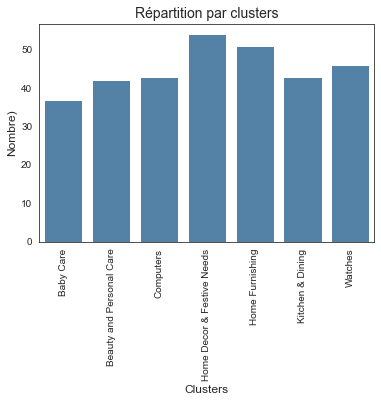

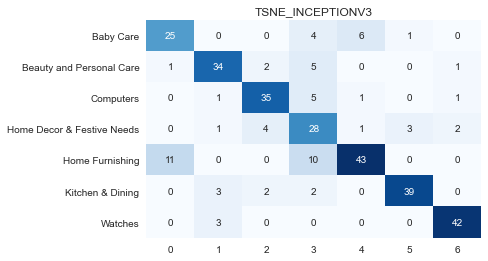

'Précision: 77.85%'

                            precision    recall  f1-score   support

                 Baby Care       0.68      0.69      0.68        36
  Beauty and Personal Care       0.81      0.79      0.80        43
                 Computers       0.81      0.81      0.81        43
Home Decor & Festive Needs       0.52      0.72      0.60        39
           Home Furnishing       0.84      0.67      0.75        64
          Kitchen & Dining       0.91      0.85      0.88        46
                   Watches       0.91      0.93      0.92        45

                  accuracy                           0.78       316
                 macro avg       0.78      0.78      0.78       316
              weighted avg       0.79      0.78      0.78       316


In [48]:
outils_nlp.classifier_pycaret(data_cat, df_incep_vectors, titre)

In [49]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_images.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                               '0.7969', '0.7785', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
5,TSNE_INCEPTIONV3,0.7969,0.7785


### <span style='background:PowderBlue'>3.7. InceptionResNetV2</span>

**ÉTAPE 1 - Import de la matrice dense sauvegardée**

In [50]:
with open('sauvegarde/df_incrn_vectors.pickle', 'rb') as vectors:
    df_incrn_vectors = pickle.load(vectors)

**ÉTAPE 2 - Classification supervisée Pycaret**

In [51]:
titre = 'INCEPTIONRESNETV2'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8133,0.9395,0.8166,0.8311,0.8136,0.7821,0.7849,0.0370
et,Extra Trees Classifier,0.8092,0.9430,0.8127,0.8236,0.8091,0.7773,0.7797,0.0350
catboost,CatBoost Classifier,0.8091,0.9482,0.8127,0.8269,0.8093,0.7773,0.7802,1.7060
xgboost,Extreme Gradient Boosting,0.8037,0.9452,0.8066,0.8171,0.8034,0.7709,0.7732,0.4730
knn,K Neighbors Classifier,0.7928,0.9277,0.7952,0.8098,0.7913,0.7580,0.7612,0.1910
lightgbm,Light Gradient Boosting Machine,0.7861,0.9444,0.7899,0.7995,0.7846,0.7503,0.7530,0.2060
gbc,Gradient Boosting Classifier,0.7765,0.9450,0.7795,0.7941,0.7788,0.7390,0.7414,0.0930
qda,Quadratic Discriminant Analysis,0.7506,0.9239,0.7567,0.7676,0.7506,0.7091,0.7119,0.0060
dt,Decision Tree Classifier,0.7464,0.8519,0.7494,0.7559,0.7441,0.7040,0.7064,0.0050
nb,Naive Bayes,0.7397,0.9168,0.7453,0.7544,0.7387,0.6964,0.6992,0.0050


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8196,0.9591,0.8233,0.8327,0.8224,0.7891,0.7905


Clusters,Nombre,%
Baby Care,44,13.92000
Beauty and Personal Care,38,12.03000
Computers,40,12.66000
Home Decor & Festive Needs,49,15.51000
Home Furnishing,54,17.09000
Kitchen & Dining,46,14.56000
Watches,45,14.24000


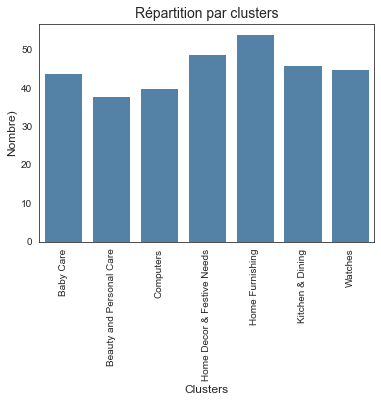

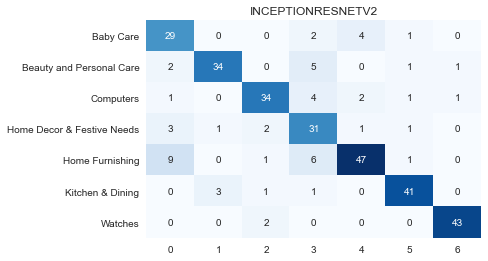

'Précision: 81.96%'

                            precision    recall  f1-score   support

                 Baby Care       0.66      0.81      0.73        36
  Beauty and Personal Care       0.89      0.79      0.84        43
                 Computers       0.85      0.79      0.82        43
Home Decor & Festive Needs       0.63      0.79      0.70        39
           Home Furnishing       0.87      0.73      0.80        64
          Kitchen & Dining       0.89      0.89      0.89        46
                   Watches       0.96      0.96      0.96        45

                  accuracy                           0.82       316
                 macro avg       0.82      0.82      0.82       316
              weighted avg       0.83      0.82      0.82       316


In [52]:
outils_nlp.classifier_pycaret(data_cat, df_incrn_vectors, titre)

In [53]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_images.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                               '0.8133', '0.8196', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
6,INCEPTIONRESNETV2,0.8133,0.8196


### <span style='background:PowderBlue'>3.8. MobileNetV2</span>

**ÉTAPE 1 - Import de la matrice dense sauvegardée**

In [54]:
with open('sauvegarde/df_mob_vectors.pickle', 'rb') as vectors:
    df_mob_vectors = pickle.load(vectors)

**ÉTAPE 2 - Classification supervisée Pycaret**

In [55]:
titre = 'TSNE_MOBILENETV2'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7847,0.9437,0.7868,0.7939,0.7827,0.7486,0.7507,0.0330
catboost,CatBoost Classifier,0.7820,0.9477,0.7835,0.7907,0.7795,0.7454,0.7474,1.6660
rf,Random Forest Classifier,0.7792,0.9461,0.7798,0.7871,0.7774,0.7422,0.7441,0.0390
knn,K Neighbors Classifier,0.7657,0.9266,0.7657,0.7778,0.7630,0.7262,0.7289,0.0070
xgboost,Extreme Gradient Boosting,0.7603,0.9377,0.7611,0.7709,0.7586,0.7201,0.7224,0.3690
gbc,Gradient Boosting Classifier,0.7546,0.9407,0.7563,0.7687,0.7543,0.7136,0.7157,0.0930
lightgbm,Light Gradient Boosting Machine,0.7494,0.9396,0.7509,0.7635,0.7504,0.7073,0.7093,0.2320
dt,Decision Tree Classifier,0.7424,0.8496,0.7412,0.7502,0.7407,0.6991,0.7009,0.0060
nb,Naive Bayes,0.6880,0.9044,0.6799,0.6972,0.6794,0.6348,0.6391,0.0050
qda,Quadratic Discriminant Analysis,0.6771,0.9096,0.6706,0.6851,0.6671,0.6222,0.6269,0.0050


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8481,0.9586,0.8441,0.8516,0.8484,0.8220,0.8224


Clusters,Nombre,%
Baby Care,38,12.03000
Beauty and Personal Care,36,11.39000
Computers,43,13.61000
Home Decor & Festive Needs,44,13.92000
Home Furnishing,61,19.30000
Kitchen & Dining,48,15.19000
Watches,46,14.56000


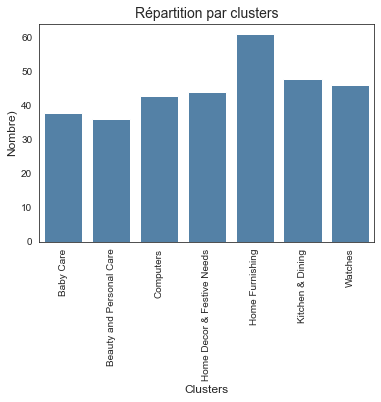

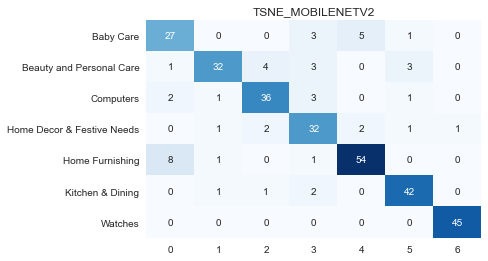

'Précision: 84.81%'

                            precision    recall  f1-score   support

                 Baby Care       0.71      0.75      0.73        36
  Beauty and Personal Care       0.89      0.74      0.81        43
                 Computers       0.84      0.84      0.84        43
Home Decor & Festive Needs       0.73      0.82      0.77        39
           Home Furnishing       0.89      0.84      0.86        64
          Kitchen & Dining       0.88      0.91      0.89        46
                   Watches       0.98      1.00      0.99        45

                  accuracy                           0.85       316
                 macro avg       0.84      0.84      0.84       316
              weighted avg       0.85      0.85      0.85       316


In [56]:
outils_nlp.classifier_pycaret(data_cat, df_mob_vectors, titre)

In [57]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_images.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                               '0.8196', '0.8481', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
7,TSNE_MOBILENETV2,0.8196,0.8481


### <span style='background:PowderBlue'>3.9. DenseNet201</span>

**ÉTAPE 1 - Import de la matrice dense sauvegardée**

In [58]:
with open('sauvegarde/df_dense_vectors.pickle', 'rb') as vectors:
    df_dense_vectors = pickle.load(vectors)

**ÉTAPE 2 - Classification supervisée Pycaret**

In [59]:
titre = 'TSNE_DENSENET201'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8092,0.9504,0.8125,0.8153,0.8057,0.7773,0.7795,0.0310
rf,Random Forest Classifier,0.8023,0.9496,0.8044,0.8101,0.7991,0.7692,0.7713,0.0370
knn,K Neighbors Classifier,0.7928,0.9308,0.7941,0.8015,0.7911,0.7580,0.7599,0.1860
catboost,CatBoost Classifier,0.7928,0.9582,0.7947,0.8001,0.7890,0.7580,0.7604,1.6890
lightgbm,Light Gradient Boosting Machine,0.7886,0.9513,0.7900,0.7956,0.7838,0.7531,0.7558,0.1980
xgboost,Extreme Gradient Boosting,0.7777,0.9520,0.7796,0.7863,0.7741,0.7404,0.7429,0.3800
gbc,Gradient Boosting Classifier,0.7764,0.9515,0.7780,0.7885,0.7728,0.7389,0.7422,0.0920
dt,Decision Tree Classifier,0.7586,0.8591,0.7593,0.7649,0.7547,0.7181,0.7204,0.0050
nb,Naive Bayes,0.7480,0.9194,0.7511,0.7587,0.7463,0.7058,0.7081,0.0050
qda,Quadratic Discriminant Analysis,0.7466,0.9225,0.7502,0.7599,0.7448,0.7042,0.7069,0.0060


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8639,0.9721,0.8606,0.8714,0.8652,0.8405,0.8412


Clusters,Nombre,%
Baby Care,38,12.03000
Beauty and Personal Care,35,11.08000
Computers,42,13.29000
Home Decor & Festive Needs,47,14.87000
Home Furnishing,63,19.94000
Kitchen & Dining,43,13.61000
Watches,48,15.19000


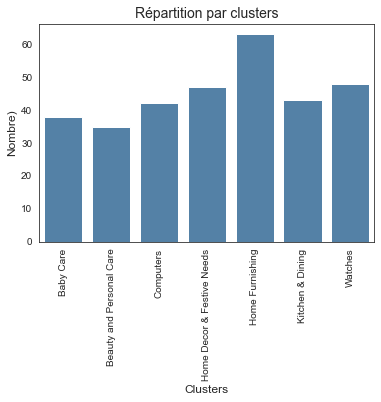

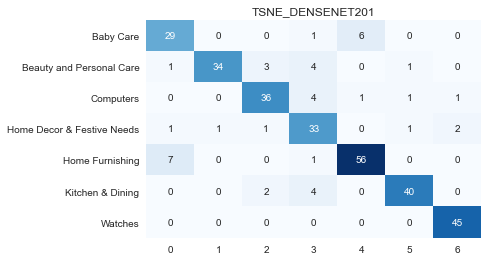

'Précision: 86.39%'

                            precision    recall  f1-score   support

                 Baby Care       0.76      0.81      0.78        36
  Beauty and Personal Care       0.97      0.79      0.87        43
                 Computers       0.86      0.84      0.85        43
Home Decor & Festive Needs       0.70      0.85      0.77        39
           Home Furnishing       0.89      0.88      0.88        64
          Kitchen & Dining       0.93      0.87      0.90        46
                   Watches       0.94      1.00      0.97        45

                  accuracy                           0.86       316
                 macro avg       0.86      0.86      0.86       316
              weighted avg       0.87      0.86      0.87       316


In [60]:
outils_nlp.classifier_pycaret(data_cat, df_dense_vectors, titre)

In [61]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_images.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                               '0.8092', '0.8639', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
8,TSNE_DENSENET201,0.8092,0.8639


### <span style='background:PowderBlue'>3.10. NASNetLarge</span>

**ÉTAPE 1 - Import de la matrice dense sauvegardée**

In [62]:
with open('sauvegarde/df_nas_vectors.pickle', 'rb') as vectors:
    df_nas_vectors = pickle.load(vectors)

**ÉTAPE 2 - Classification supervisée Pycaret**

In [63]:
titre = 'TSNE_NASNETLARGE'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7875,0.9342,0.7885,0.8007,0.7877,0.7519,0.7539,0.0320
xgboost,Extreme Gradient Boosting,0.7847,0.9369,0.7843,0.7983,0.7833,0.7486,0.7512,0.3830
rf,Random Forest Classifier,0.7833,0.9404,0.7829,0.7963,0.7817,0.7470,0.7496,0.0370
catboost,CatBoost Classifier,0.7806,0.9456,0.7804,0.7945,0.7781,0.7438,0.7468,1.7270
lightgbm,Light Gradient Boosting Machine,0.7765,0.9420,0.7767,0.7892,0.7762,0.7390,0.7412,0.2170
gbc,Gradient Boosting Classifier,0.7697,0.9420,0.7678,0.7816,0.7688,0.7311,0.7333,0.0910
knn,K Neighbors Classifier,0.7684,0.9201,0.7669,0.7831,0.7686,0.7293,0.7316,0.1930
dt,Decision Tree Classifier,0.7479,0.8528,0.7443,0.7522,0.7451,0.7054,0.7070,0.0050
lr,Logistic Regression,0.6471,0.8901,0.6399,0.6614,0.6421,0.5871,0.5904,0.3490
qda,Quadratic Discriminant Analysis,0.6418,0.8947,0.6470,0.6577,0.6217,0.5826,0.5911,0.0060


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8259,0.9601,0.8233,0.8342,0.8273,0.7960,0.7968


Clusters,Nombre,%
Baby Care,41,12.97000
Beauty and Personal Care,37,11.71000
Computers,41,12.97000
Home Decor & Festive Needs,47,14.87000
Home Furnishing,64,20.25000
Kitchen & Dining,39,12.34000
Watches,47,14.87000


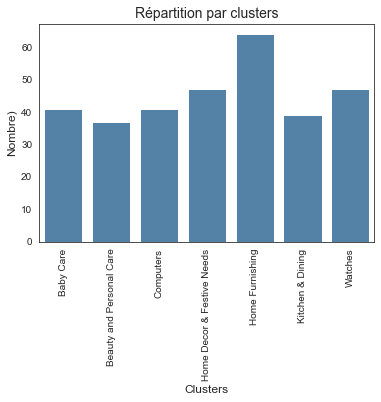

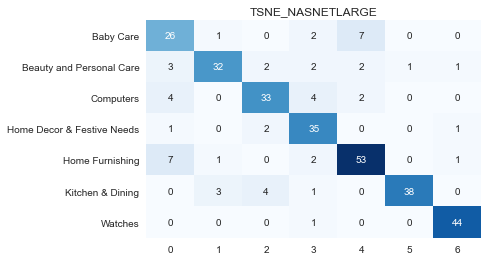

'Précision: 82.59%'

                            precision    recall  f1-score   support

                 Baby Care       0.63      0.72      0.68        36
  Beauty and Personal Care       0.86      0.74      0.80        43
                 Computers       0.80      0.77      0.79        43
Home Decor & Festive Needs       0.74      0.90      0.81        39
           Home Furnishing       0.83      0.83      0.83        64
          Kitchen & Dining       0.97      0.83      0.89        46
                   Watches       0.94      0.98      0.96        45

                  accuracy                           0.83       316
                 macro avg       0.83      0.82      0.82       316
              weighted avg       0.83      0.83      0.83       316


In [64]:
outils_nlp.classifier_pycaret(data_cat, df_nas_vectors, titre)

In [65]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_images.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                               '0.7875', '0.8259', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
9,TSNE_NASNETLARGE,0.7875,0.8259


### <span style='background:PowderBlue'>3.11. EfficientNetB7</span>

**ÉTAPE 1 - Import de la matrice dense sauvegardée**

In [66]:
with open('sauvegarde/df_eff_vectors.pickle', 'rb') as vectors:
    df_eff_vectors = pickle.load(vectors)

**ÉTAPE 2 - Classification supervisée Pycaret**

In [73]:
titre = 'TSNE_EFFICIENTNETB7'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7820,0.9436,0.7829,0.7918,0.7797,0.7456,0.7478,1.7130
rf,Random Forest Classifier,0.7778,0.9378,0.7785,0.7888,0.7766,0.7406,0.7428,0.0340
et,Extra Trees Classifier,0.7778,0.9340,0.7777,0.7857,0.7744,0.7406,0.7428,0.0320
knn,K Neighbors Classifier,0.7724,0.9190,0.7726,0.7821,0.7697,0.7342,0.7365,0.1830
xgboost,Extreme Gradient Boosting,0.7615,0.9400,0.7611,0.7737,0.7600,0.7215,0.7238,0.3610
lightgbm,Light Gradient Boosting Machine,0.7560,0.9400,0.7570,0.7620,0.7528,0.7152,0.7172,0.2130
gbc,Gradient Boosting Classifier,0.7491,0.9354,0.7490,0.7621,0.7478,0.7070,0.7096,0.0890
dt,Decision Tree Classifier,0.7273,0.8407,0.7270,0.7369,0.7266,0.6814,0.6832,0.0050
qda,Quadratic Discriminant Analysis,0.6756,0.9057,0.6793,0.6842,0.6694,0.6216,0.6251,0.0050
nb,Naive Bayes,0.6416,0.8971,0.6473,0.6597,0.6309,0.5821,0.5879,0.0050


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7880,0.9614,0.7875,0.8100,0.7945,0.7521,0.7540


Clusters,Nombre,%
Baby Care,53,16.77000
Beauty and Personal Care,36,11.39000
Computers,38,12.03000
Home Decor & Festive Needs,41,12.97000
Home Furnishing,56,17.72000
Kitchen & Dining,47,14.87000
Watches,45,14.24000


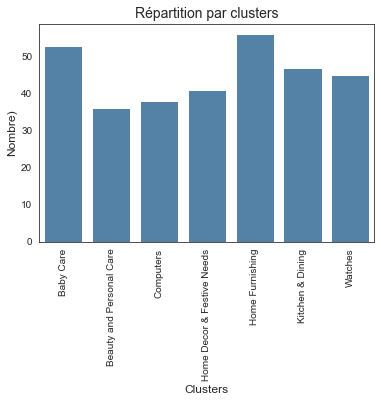

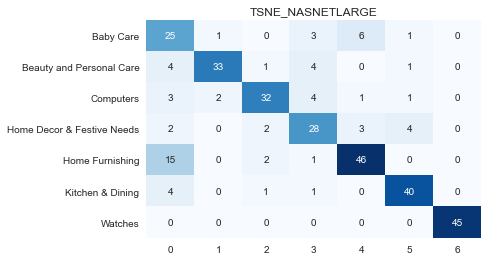

'Précision: 78.8%'

                            precision    recall  f1-score   support

                 Baby Care       0.47      0.69      0.56        36
  Beauty and Personal Care       0.92      0.77      0.84        43
                 Computers       0.84      0.74      0.79        43
Home Decor & Festive Needs       0.68      0.72      0.70        39
           Home Furnishing       0.82      0.72      0.77        64
          Kitchen & Dining       0.85      0.87      0.86        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.79       316
                 macro avg       0.80      0.79      0.79       316
              weighted avg       0.81      0.79      0.79       316


In [68]:
outils_nlp.classifier_pycaret(data_cat, df_eff_vectors, titre)

In [75]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_images.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                               '0.7820', '0.7880', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
10,TSNE_EFFICIENTNETB7,0.7820,0.7880


### <span style='background:PowderBlue'>3.12. Combinaison données textuelles et données images</span>

Le but est de combiner les matrices denses réduites des 2 meilleurs algorithmes des données textuelles et des données images :
- [X] DenseNet201 (Images, Accuray train=86%, Accuracy test=81%)
- [X] Use (version 5, textes, Accuray train=94%, Accuracy test=96%)

**ÉTAPE 1 - Import de la matrice dense sauvegardée**

In [20]:
# Chargement de la matrice dense réduite par TSNE des données :
# textuelles USE version 5 pour les produits spécifications lemmatisés
with open('sauvegarde/vector_use5_prod_lem.pickle', 'rb') as vectors:
    vector_use5_prod_lem = pickle.load(vectors)
# Transforme Tensorflow en dataframe
df_use5_prod_lem = pd.DataFrame(np.array(vector_use5_prod_lem))

In [22]:
# Chargement de la matrice dense réduite par TSNE des données :
# images DenseNet201
with open('sauvegarde/df_dense_vectors.pickle', 'rb') as vectors:
    df_dense_vectors = pickle.load(vectors)

In [35]:
# Concaténation des matrices denses réduites des données textuelles et
# des images
df_combi_vectors = pd.concat([df_use5_prod_lem, df_dense_vectors],
                             axis=1, ignore_index=True)

**ÉTAPE 2 - Classification supervisée Pycaret**

In [36]:
titre = 'TSNE_COMBI_USE5_DENSENET201'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8078,0.9501,0.8118,0.8226,0.8051,0.7756,0.7785,0.0340
et,Extra Trees Classifier,0.8010,0.9505,0.8037,0.8184,0.7994,0.7677,0.7705,0.0320
catboost,CatBoost Classifier,0.8009,0.9525,0.8036,0.8083,0.7994,0.7676,0.7692,1.6740
gbc,Gradient Boosting Classifier,0.7874,0.9510,0.7874,0.7977,0.7860,0.7516,0.7537,0.0890
xgboost,Extreme Gradient Boosting,0.7872,0.9472,0.7866,0.7963,0.7860,0.7514,0.7533,0.3400
lightgbm,Light Gradient Boosting Machine,0.7819,0.9506,0.7825,0.7957,0.7812,0.7452,0.7476,0.2310
knn,K Neighbors Classifier,0.7778,0.9369,0.7811,0.7870,0.7750,0.7406,0.7430,0.1860
dt,Decision Tree Classifier,0.7724,0.8669,0.7738,0.7774,0.7697,0.7341,0.7357,0.0060
lda,Linear Discriminant Analysis,0.6974,0.8932,0.6982,0.7122,0.6898,0.6465,0.6507,0.0060
nb,Naive Bayes,0.6920,0.9092,0.6927,0.7047,0.6802,0.6401,0.6446,0.0060


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8481,0.9644,0.8381,0.8520,0.8481,0.8215,0.8221


Clusters,Nombre,%
Baby Care,34,10.76000
Beauty and Personal Care,35,11.08000
Computers,42,13.29000
Home Decor & Festive Needs,43,13.61000
Home Furnishing,69,21.84000
Kitchen & Dining,45,14.24000
Watches,48,15.19000


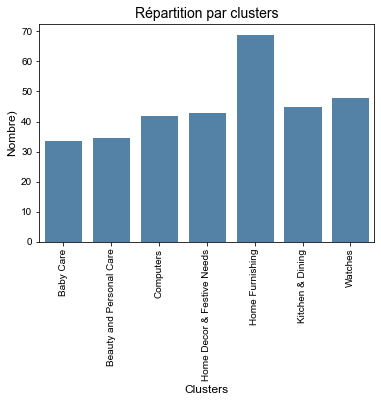

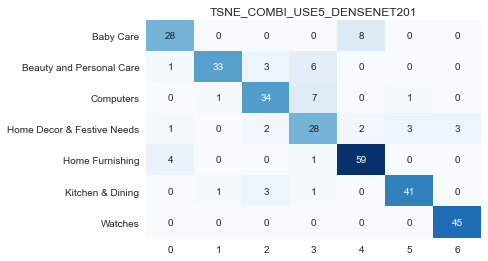

'Précision: 84.81%'

                            precision    recall  f1-score   support

                 Baby Care       0.82      0.78      0.80        36
  Beauty and Personal Care       0.94      0.77      0.85        43
                 Computers       0.81      0.79      0.80        43
Home Decor & Festive Needs       0.65      0.72      0.68        39
           Home Furnishing       0.86      0.92      0.89        64
          Kitchen & Dining       0.91      0.89      0.90        46
                   Watches       0.94      1.00      0.97        45

                  accuracy                           0.85       316
                 macro avg       0.85      0.84      0.84       316
              weighted avg       0.85      0.85      0.85       316


In [37]:
outils_nlp.classifier_pycaret(data_cat, df_combi_vectors, titre)

In [39]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_images.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                               '0.8078', '0.8481', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

,Unnamed: 0,Type_données,Accuracy_train,Accuracy_test
11,NaN,TSNE_COMBI_USE5_DENSENET201,0.8078,0.8481


### <span style='background:PowderBlue'>3.13. Comparaison des précisions</span>

In [40]:
# Chargement des dataframes de sauvegarde des scores classif supervisée
#  des algorithmes ORB et SIFT
df_scores_img_classique = pd.read_csv('IMAGES_data_scores_class_sup.csv')
df_scores_img_classique = df_scores_img_classique.drop(columns=['Unnamed: 0'])

In [46]:
# Chargement des dataframes de sauvegarde des scores classif supervisée
# des cnn
df_scores_img_cnn = pd.read_csv('data_accuracy_classification_images.csv')
df_scores_img_cnn = df_scores_img_cnn.drop(columns=['Unnamed: 0'])
df_scores_img_cnn = df_scores_img_cnn.drop(columns=['Unnamed: 0.1'])

In [48]:
# Concaténation des 2 dataframes de scores images classiques + cnn
df_scores_img_classup = pd.concat([df_scores_img_classique,
                                   df_scores_img_cnn])

In [49]:
df_scores_img_classup['Accuracy_train'] = \
    df_scores_img_classup['Accuracy_train'].astype(float)
df_scores_img_classup['Accuracy_test'] = \
    df_scores_img_classup['Accuracy_test'].astype(float)

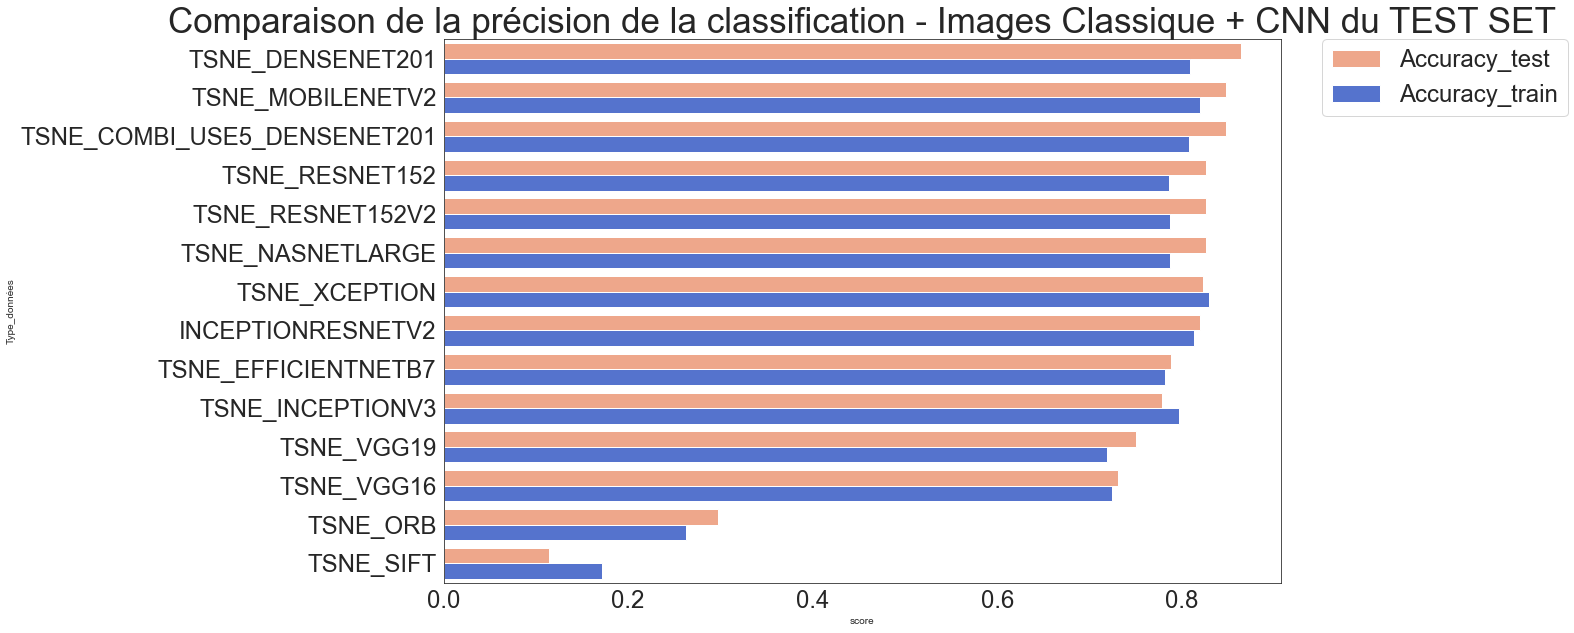

In [50]:
# TEST SET
# -----------------------------------------------------------------------
# Comparaison visuelle des algorithmes les plus performants sur le TEST SET
df_scores_img_classup_sort = \
    df_scores_img_classup.sort_values(by='Accuracy_test', ascending=False)
compimgclassup_score_melt = pd.melt(df_scores_img_classup_sort,
                                    id_vars=['Type_données'],
                                    value_name='score',
                                    value_vars=['Accuracy_test',
                                                'Accuracy_train'])
# Visualisation
plt.figure(figsize=(15, 10))
sns.barplot(y=compimgclassup_score_melt['Type_données'],
            x=compimgclassup_score_melt['score'],
            hue=compimgclassup_score_melt['variable'],
            palette=['LightSalmon', 'RoyalBlue'])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
tit1 = 'Comparaison de la précision de la classification - '
tit2 = 'Images Classique + CNN du TEST SET'
plt.title(tit1 + tit2, fontsize=35)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=24)
plt.show()

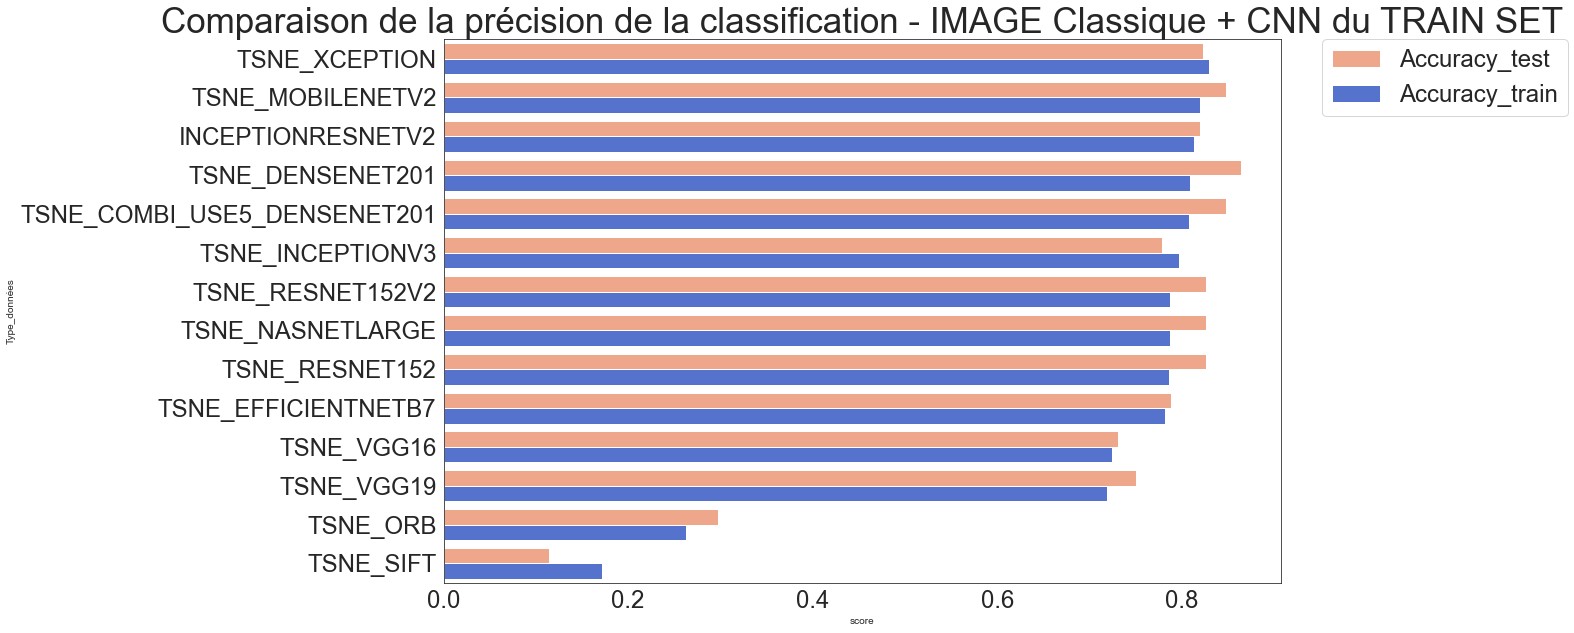

In [52]:
# TRAIN SET
# -----------------------------------------------------------------------
# Comparaison visuelle des algorithmes les plus performants sur le TRAIN SET
df_scores_img_classup_sort_train = \
    df_scores_img_classup.sort_values(by='Accuracy_train', ascending=False)
compimgclassuptrain_score_melt = pd.melt(df_scores_img_classup_sort_train,
                                         id_vars=['Type_données'],
                                         value_name='score',
                                         value_vars=['Accuracy_test',
                                                     'Accuracy_train'])
# Visualisation
plt.figure(figsize=(15, 10))
sns.barplot(y=compimgclassuptrain_score_melt['Type_données'],
            x=compimgclassuptrain_score_melt['score'],
            hue=compimgclassuptrain_score_melt['variable'],
            palette=['LightSalmon', 'RoyalBlue'])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
tit1 = 'Comparaison de la précision de la classification - '
tit2 = 'IMAGE Classique + CNN du TRAIN SET'
plt.title(tit1 + tit2, fontsize=35)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=24)
plt.show()

In [53]:
# TOP 10 des résultats de classification sur le TRAIN SET
df_scores_img_classup_sort_train

,Type_données,Accuracy_train,Accuracy_test
2,TSNE_XCEPTION,0.8296,0.8228
7,TSNE_MOBILENETV2,0.8196,0.8481
6,INCEPTIONRESNETV2,0.8133,0.8196
8,TSNE_DENSENET201,0.8092,0.8639
11,TSNE_COMBI_USE5_DENSENET201,0.8078,0.8481
5,TSNE_INCEPTIONV3,0.7969,0.7785
4,TSNE_RESNET152V2,0.7875,0.8259
9,TSNE_NASNETLARGE,0.7875,0.8259
3,TSNE_RESNET152,0.7859,0.8259
10,TSNE_EFFICIENTNETB7,0.7820,0.7880


In [54]:
# TOP 10 des résultats de classification sur le TEST SET
df_scores_img_classup_sort

,Type_données,Accuracy_train,Accuracy_test
8,TSNE_DENSENET201,0.8092,0.8639
7,TSNE_MOBILENETV2,0.8196,0.8481
11,TSNE_COMBI_USE5_DENSENET201,0.8078,0.8481
3,TSNE_RESNET152,0.7859,0.8259
4,TSNE_RESNET152V2,0.7875,0.8259
9,TSNE_NASNETLARGE,0.7875,0.8259
2,TSNE_XCEPTION,0.8296,0.8228
6,INCEPTIONRESNETV2,0.8133,0.8196
10,TSNE_EFFICIENTNETB7,0.7820,0.7880
5,TSNE_INCEPTIONV3,0.7969,0.7785


**Bilan** :
- Les méthodes CNN sont loin devant les anciens algorithmes ORB et SIFT avec une précision supérieures à 72% pour les CNN et inférieure à 26% pour ORB et 17% pour SIFT.

## <span style='background:Thistle'>4. BILAN FINAL CLASSIFICATION SUPERVISÉE</span>

### <span style='background:PowderBlue'>4.1. Comparaison des scores ARI/précisions - TEXTES / IMAGES / COMBINAISON</span>

**Données Textuelles**

In [13]:
# Chargement des données de sauvegarde des résultats des scores KMeans
df_scores_textes = pd.read_csv('data_accuracy_classification.csv')
# Supprime variable Unnamed: 0
df_scores_textes.drop('Unnamed: 0', axis=1, inplace=True)
df_scores_textes.shape

(62, 3)

In [15]:
# Ajout du type TEXTE
df_scores_textes['TYPE'] = 'TEXTE'

**Données images**

In [14]:
# Chargement des dataframes de sauvegarde des scores
df_scores_img = pd.read_csv('data_accuracy_classification_images.csv')
# Supprime variable Unnamed: 0
df_scores_img.drop('Unnamed: 0', axis=1, inplace=True)
df_scores_img.drop('Unnamed: 0.1', axis=1, inplace=True)
df_scores_img.shape

(12, 3)

In [16]:
# Ajout du type IMAGE
df_scores_img['TYPE'] = 'IMAGE'
# Ajout du type COMBINAISON
df_scores_img.loc[11, 'TYPE'] = 'COMBINAISON'

**Données textes + images**

In [17]:
# Concaténation des 2 dataframes de scores textes + images
df_comparaison = pd.concat([df_scores_textes, df_scores_img])
df_comparaison.shape

(74, 4)

**Comparaison des accuracy test set des textes et des images**

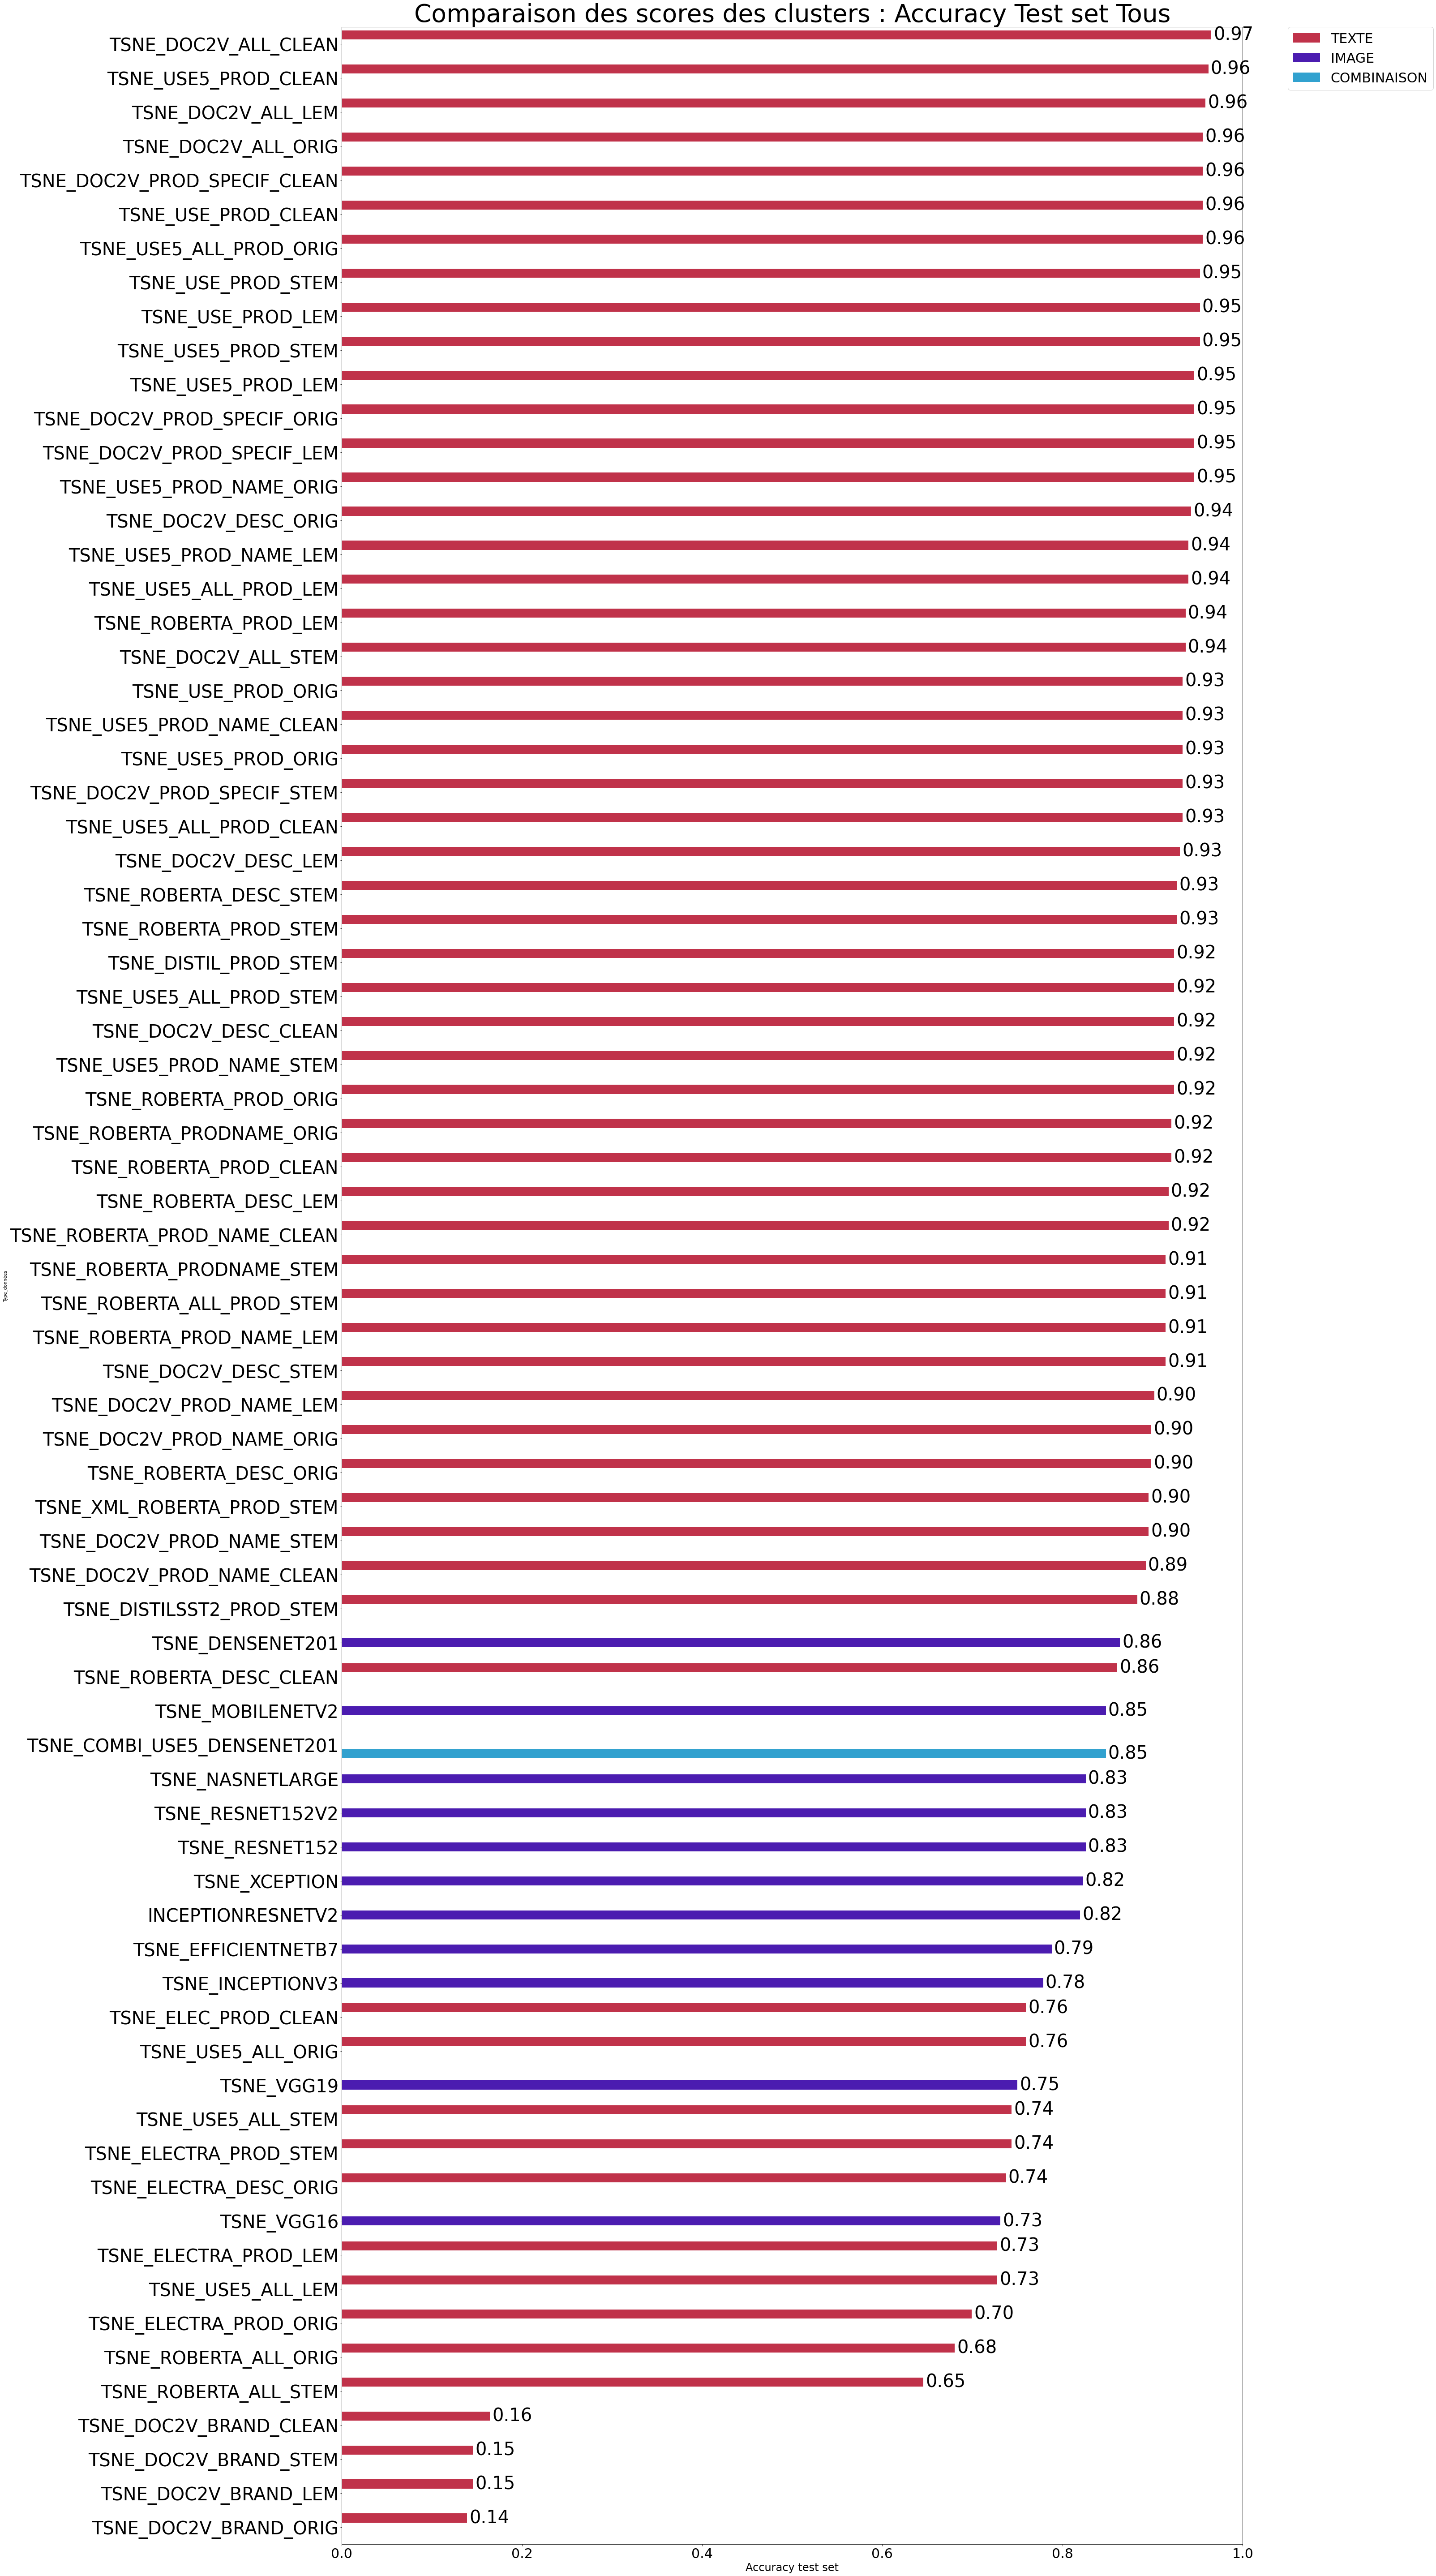

In [18]:
# Comparaison visuelle des algorithmes saccuracy du test set Textes + Images
df_comp_sort = df_comparaison.sort_values(by='Accuracy_test', ascending=False)
comparaison_score_melt = pd.melt(df_comp_sort, id_vars=['Type_données',
                                                        'TYPE'],
                                 value_name='score',
                                 value_vars=['Accuracy_test'])
# Visualisation
fig, ax = plt.subplots(1, 1, figsize=(45, 80))

ax = sns.barplot(y=comparaison_score_melt['Type_données'],
                 x=comparaison_score_melt['score'],
                 hue=comparaison_score_melt['TYPE'],
                 palette=['#d71b3b', '#4203c9', '#16acea'])
ax.set_title('Comparaison des scores des clusters : Accuracy Test set Tous',
             fontsize=55)
for p in ax.patches:
    ax.annotate('%.2f' % p.get_width(), xy=(p.get_width(),
                                            p.get_y()+p.get_height()/2),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=40)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)
plt.xlim(0, 1)
plt.xlabel('Accuracy test set', fontsize=24)

fig.tight_layout()

plt.show()

**Comparaison des accuracy train set des textes et des images**

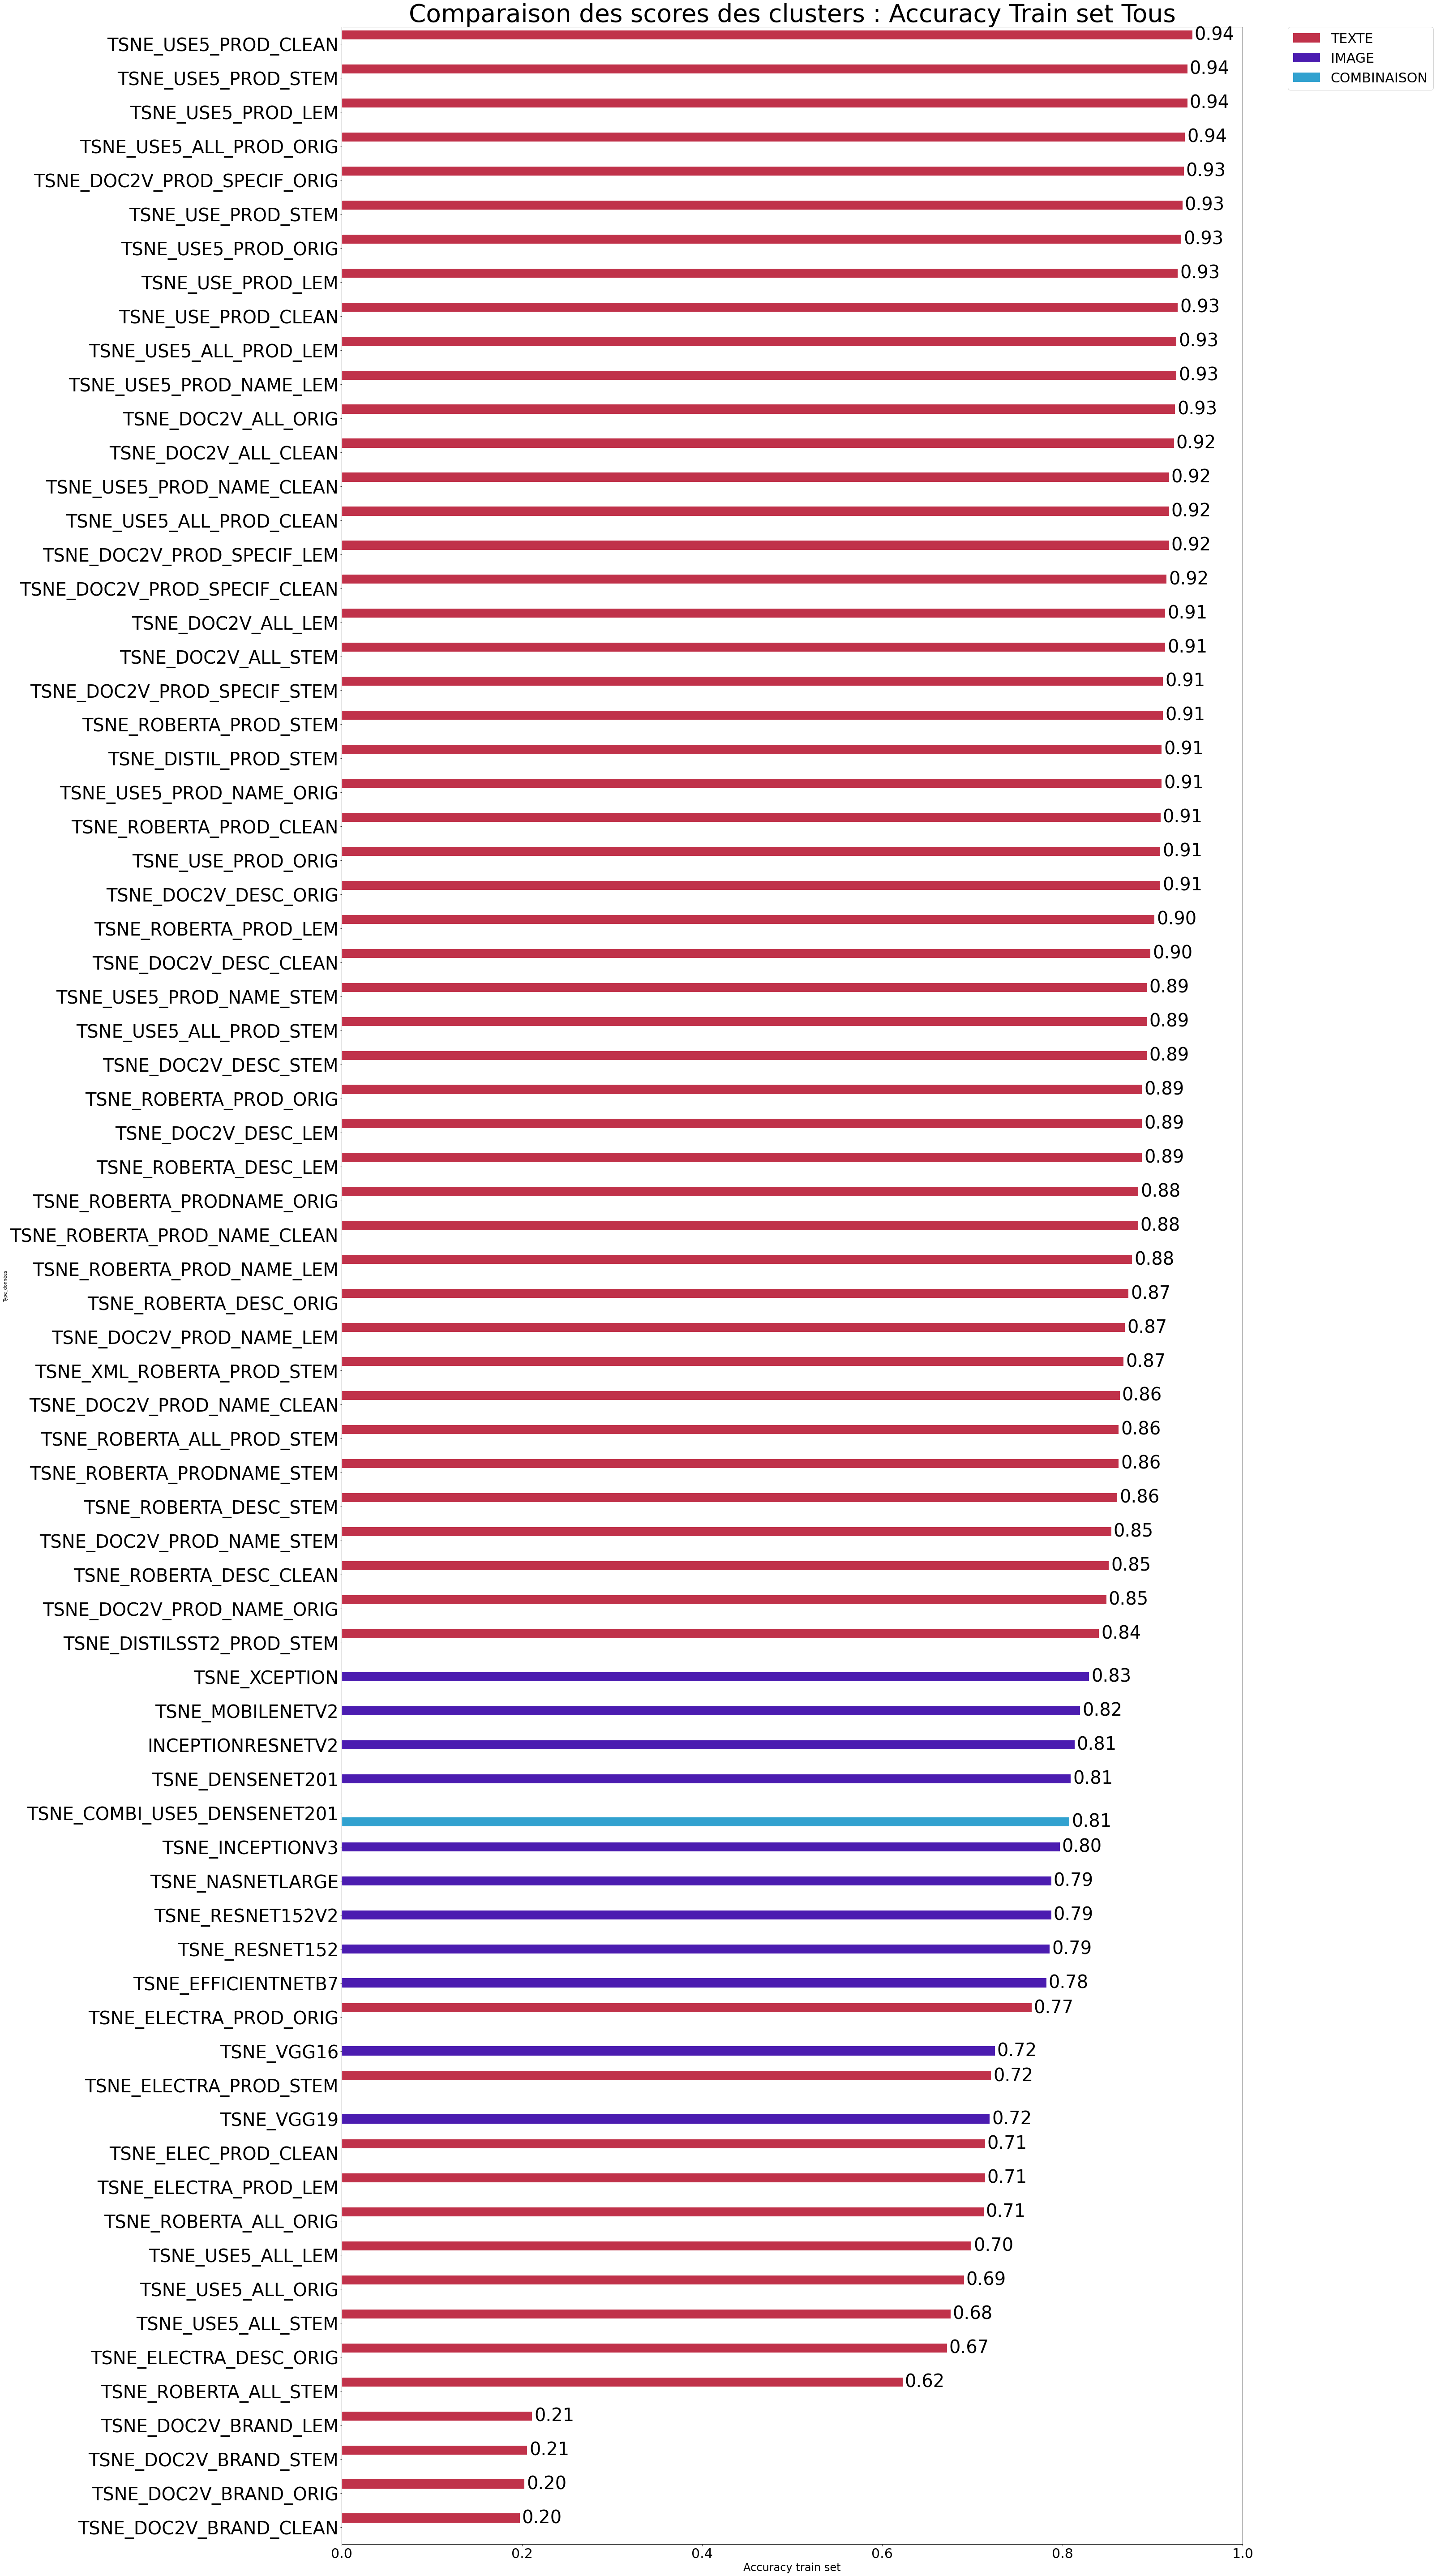

In [19]:
# Comparaison visuelle des algorithmes saccuracy du train set Textes + Images
df_comp_sort = df_comparaison.sort_values(by='Accuracy_train', ascending=False)
comparaison_score_melt = pd.melt(df_comp_sort, id_vars=['Type_données',
                                                        'TYPE'],
                                 value_name='score',
                                 value_vars=['Accuracy_train'])
# Visualisation
fig, ax = plt.subplots(1, 1, figsize=(45, 80))

ax = sns.barplot(y=comparaison_score_melt['Type_données'],
                 x=comparaison_score_melt['score'],
                 hue=comparaison_score_melt['TYPE'],
                 palette=['#d71b3b', '#4203c9', '#16acea'])
ax.set_title('Comparaison des scores des clusters : Accuracy Train set Tous',
             fontsize=55)
for p in ax.patches:
    ax.annotate('%.2f' % p.get_width(), xy=(p.get_width(),
                                            p.get_y()+p.get_height()/2),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=40)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)
plt.xlim(0, 1)
plt.xlabel('Accuracy train set', fontsize=24)

fig.tight_layout()

plt.show()

### <span style='background:PowderBlue'>4.2. Comparaison des scores ARI/précisions - Top 5 TEXTES/IMAGES et la COMBINAISON</span>

**Préparation des données**

***Données textuelles***

In [20]:
# Top 5 des accuracys test set données textuelles
df_top5_textes = df_scores_textes.sort_values(by='Accuracy_test',
                                              ascending=False)[0:5]

In [21]:
liste_top5_textes = df_top5_textes['Type_données'].to_list()

***Données images***

In [22]:
# Top 5 des accuracys test set données images
df_top5_img = df_scores_img[0:-1].sort_values(by='Accuracy_test',
                                              ascending=False)[0:5]

***Combinaison textes + images***

In [23]:
# Récupération de l'accuracy test set de la combinaison TEXTE + IMAGE
df_combi = df_scores_img.tail(1)

**Comparaison des accuracy du TEST SET**

In [24]:
# Dataframe de comparaison des scores ARI et de la précision
df_comparaison_top = pd.concat([df_top5_textes, df_top5_img,
                                df_combi])
# Supprime la ligne des types d'objet
df_comparaison_top['Accuracy_test'] = \
    df_comparaison_top['Accuracy_test'].astype(float)

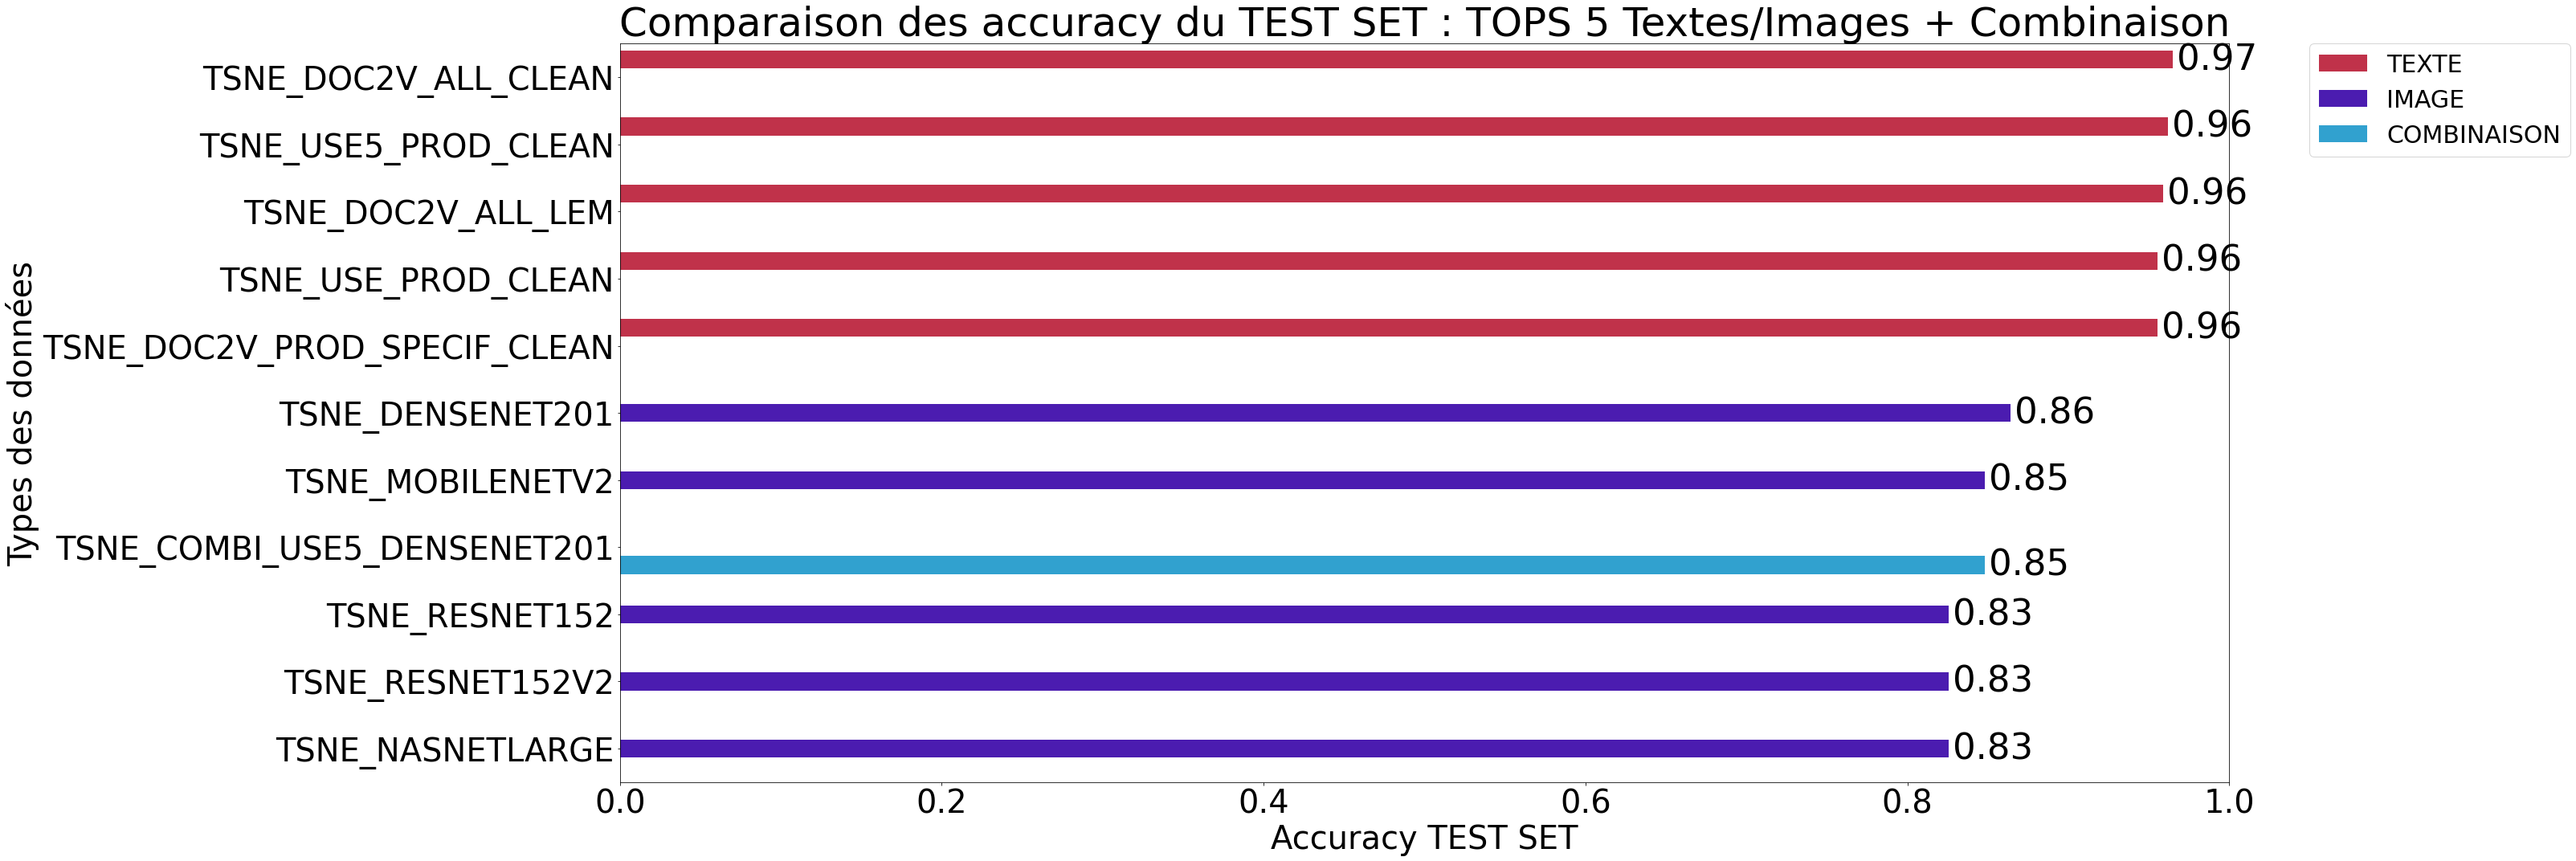

In [28]:
# Comparaison visuelle des algorithmes score ARI Textes + Images
df_comp_top_sort = df_comparaison_top.sort_values(by='Accuracy_test',
                                                  ascending=False)
comparaison_top_score_melt = pd.melt(df_comp_top_sort,
                                     id_vars=['Type_données', 'TYPE'],
                                     value_name='score',
                                     value_vars=['Accuracy_test'])
# Visualisation
fig, ax = plt.subplots(1, 1, figsize=(45, 15))

ax = sns.barplot(y=comparaison_top_score_melt['Type_données'],
                 x=comparaison_top_score_melt['score'],
                 hue=comparaison_top_score_melt['TYPE'],
                 palette=['#d71b3b', '#4203c9', '#16acea'])
titre = 'Comparaison des accuracy du TEST SET : '
titre1 = 'TOPS 5 Textes/Images + Combinaison'
ax.set_title(titre + titre1,
             fontsize=50)
for p in ax.patches:
    ax.annotate('%.2f' % p.get_width(), xy=(p.get_width(),
                                            p.get_y()+p.get_height()/2),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=45)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(0, 1)
plt.xlabel('Accuracy TEST SET', fontsize=40)
plt.ylabel('Types des données', fontsize=40)

fig.tight_layout()

plt.show()

### <span style='background:PowderBlue'>4.3. Exemples des erreurs d'étiquettage des catégories</span>

In [26]:
def path_to_image_photo_html(path):
    return '<img src="' + path + ' " width="100">'

In [27]:
df_visu_image_mal_rangee = data.loc[[63, 85, 73, 222, 672, 666, 1048],
                                    ['image_loc', 'Categorie_1']]
display(HTML(df_visu_image_mal_rangee.
             to_html(escape=False,
                     formatters=dict(image_loc=path_to_image_photo_html))))

,image_loc,Categorie_1
63,,Baby Care
85,,Home Decor & Festive Needs
73,,Baby Care
222,,Home Decor & Festive Needs
672,,Baby Care
666,,Baby Care
1048,,Baby Care
